In [1]:
#!pip install opencv-python
#!pip install keras
#!pip install tensorflow


In [2]:
import keras
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.
W0730 11:27:32.389045 17184 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


In [8]:
infected = os.listdir(r'C:/Users/INFO-DSK-04/Desktop/Malaria_Cells_Image_classification/cell_images/Parasitized') 
uninfected = os.listdir(r'C:/Users/INFO-DSK-04/Desktop/Malaria_Cells_Image_classification/cell_images/Uninfected')

In [9]:
data = []
labels = []

for i in infected:
    try:
    
        image = cv2.imread(r"C:/Users/INFO-DSK-04/Desktop/Malaria_Cells_Image_classification/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
        
    except AttributeError:
        print('')
    
for u in uninfected:
    try:
        
        image = cv2.imread(r"C:/Users/INFO-DSK-04/Desktop/Malaria_Cells_Image_classification/cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        labels.append(0)
        labels.append(0)
        labels.append(0)
        
    except AttributeError:
        print('')

In [10]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

In [11]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))

Cells : (96433, 50, 50, 3) | labels : (96433,)


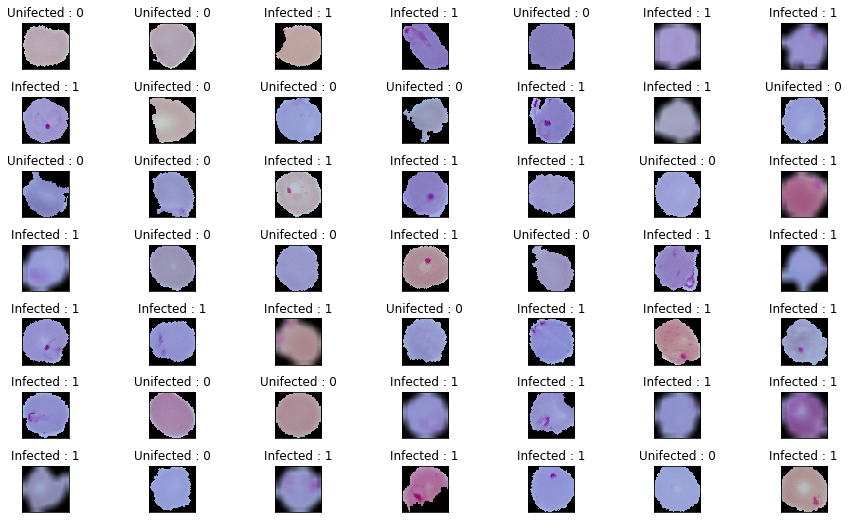

In [12]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.6 , wspace = 0.6)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

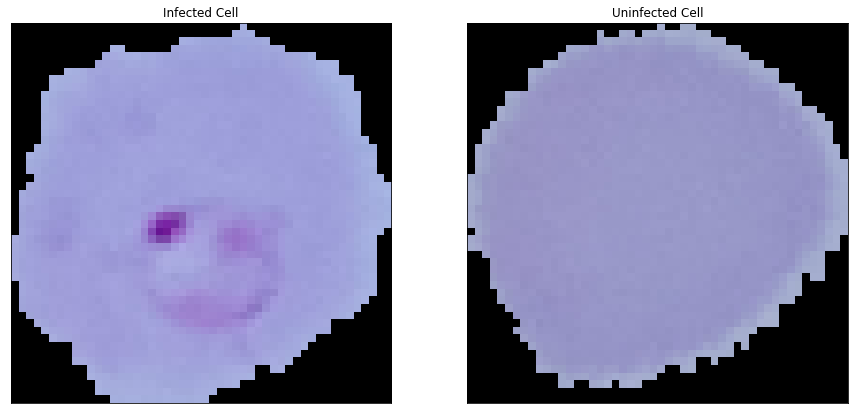

In [13]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[0])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[60000])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()


In [14]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [15]:
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

In [16]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

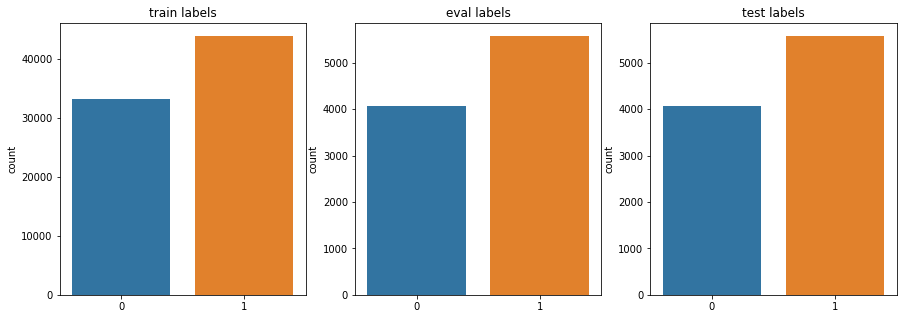

In [17]:
import seaborn as sns
plt.figure(1 , figsize = (15 ,5))
n = 0 
for z , j in zip([train_y , eval_y , test_y] , ['train labels','eval labels','test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()


In [18]:
print('train data shape {} ,eval data shape {} , test data shape {}'.format(train_x.shape,
                                                                           eval_x.shape ,
                                                                           test_x.shape))

train data shape (77146, 50, 50, 3) ,eval data shape (9643, 50, 50, 3) , test data shape (9644, 50, 50, 3)


In [19]:
import tensorflow as tf
tf.reset_default_graph()
def cnn_model_fn(features , labels , mode):
    input_layers = tf.reshape(features['x'] , [-1 , 50 , 50 ,3])    
    conv1 = tf.layers.conv2d(
        inputs = input_layers , 
        filters = 50 , 
        kernel_size = [7 , 7],
        padding = 'same',
        activation = tf.nn.relu
        ) 
    
    
    conv2 = tf.layers.conv2d(
        inputs = conv1, 
        filters = 90,
        kernel_size = [3 , 3],
        padding = 'valid',
        activation = tf.nn.relu
        )

        
    conv3 = tf.layers.conv2d(
        inputs = conv2 ,
        filters = 10,
        kernel_size = [5 , 5],
        padding = 'same', 
        activation = tf.nn.relu
        )
    
    pool1 = tf.layers.max_pooling2d(inputs = conv3 , pool_size = [2 , 2] ,
                                    strides = 2 )
    conv4 = tf.layers.conv2d(
        inputs = pool1 ,
        filters = 5,
        kernel_size = [3 , 3],
        padding = 'same', 
        activation = tf.nn.relu
        )

    pool2 = tf.layers.max_pooling2d(inputs = conv4 , pool_size = [2 , 2] ,
                                    strides = 2 , padding = 'same')
    
    pool2_flatten = tf.layers.flatten(pool2)
    fc1 = tf.layers.dense(
        inputs = pool2_flatten,
        units = 2000,
        activation = tf.nn.relu
        )
    fc2 = tf.layers.dense(
        inputs = fc1,
        units = 1000,
        activation = tf.nn.relu
        )
    fc3 = tf.layers.dense(
        inputs = fc2 , 
        units = 500 ,
        activation = tf.nn.relu
        )
    logits = tf.layers.dense(
        inputs = fc3 ,
        units = 2
        )
    
    predictions = {
        'classes': tf.argmax(input = logits , axis = 1),
        'probabilities': tf.nn.softmax(logits , name = 'softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode , 
                                          predictions = predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels , 
                                                 logits = logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(loss = loss , 
                                      global_step = tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode = mode , 
                                            loss = loss , 
                                            train_op = train_op 
                                           )
    eval_metric_op = {'accuracy' : tf.metrics.accuracy(labels = labels ,
                                         predictions =  predictions['classes'])}
    
    return tf.estimator.EstimatorSpec(mode = mode , 
                                      loss = loss , 
                                      eval_metric_ops = eval_metric_op)    

In [20]:
malaria_detector = tf.estimator.Estimator(model_fn = cnn_model_fn , 
                                         model_dir = '/tmp/modelchkpt')

In [21]:
tensors_to_log = {'probabilities':'softmax_tensor'}
logging_hook = tf.train.LoggingTensorHook(
    tensors = tensors_to_log , every_n_iter = 50 
    )

In [22]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': train_x},
    y = train_y,
    batch_size = 100 , 
    num_epochs = None , 
    shuffle = True
    )
malaria_detector.train(input_fn = train_input_fn , steps = 1 , hooks = [logging_hook])

W0730 11:32:17.430694 17184 deprecation.py:323] From C:\Users\INFO-DSK-04\Anaconda3\lib\site-packages\tensorflow\python\training\training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0730 11:32:17.452608 17184 deprecation.py:323] From C:\Users\INFO-DSK-04\Anaconda3\lib\site-packages\tensorflow_estimator\python\estimator\inputs\queues\feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0730 11:32:17.454603 17184 deprecation.py:323] From C:\Users\INFO-DSK-04\Anaconda3\lib\site-packages\tensorflow_estimator\python\estimator\inputs\queues\feeding_functions.py:500: add_

In [23]:
malaria_detector.train(input_fn = train_input_fn , steps = 10000)

W0730 11:32:57.026927 17184 deprecation.py:323] From C:\Users\INFO-DSK-04\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0730 11:32:57.088019 17184 deprecation.py:323] From C:\Users\INFO-DSK-04\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1066: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


KeyboardInterrupt: 